In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from torchvision import transforms
from timm import create_model
from google.colab import drive
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import time
import torch.nn as nn

In [ ]:
# ============================
# 1. MOUNT GOOGLE DRIVE
# ============================
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================
# 2. LOAD CLEANED DATASET
# ============================
dataset_path = "/content/drive/MyDrive/dataset/cleaned_dataset.csv"
df = pd.read_csv(dataset_path)

print("Dataset loaded successfully!")
df.head()  # Display first few rows

Dataset loaded successfully!


,image_path,class,class_name
0,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell
1,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell
2,/content/drive/MyDrive/dataset/thin_films_part...,1,Sickle Cell
3,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell
4,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell


<ipython-input-4-067ec2d75ac5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["class"], palette="viridis")


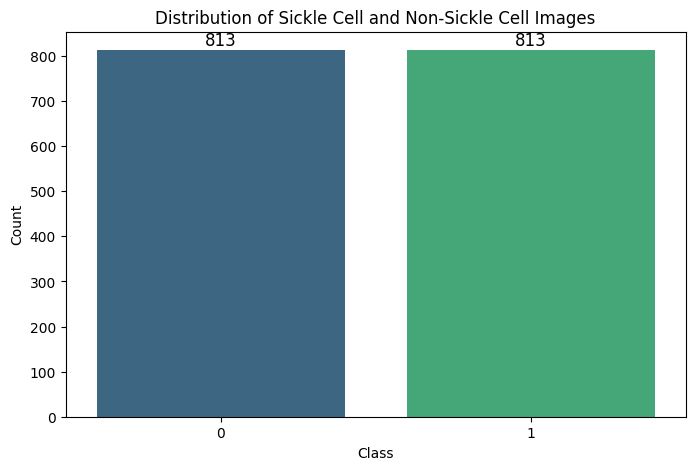

In [ ]:
# ============================
# 3. DATA VISUALIZATION
# ============================
## Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df["class"], palette="viridis")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Sickle Cell and Non-Sickle Cell Images")
for i, v in enumerate(df["class"].value_counts()):
    plt.text(i, v + 10, str(v), ha='center', fontsize=12)
plt.show()

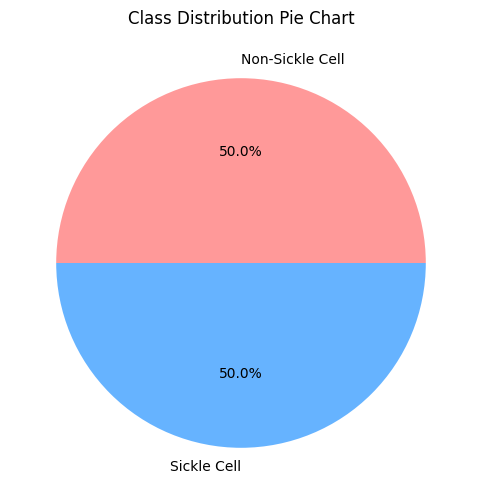

In [ ]:
## Pie Chart of Class Distribution
plt.figure(figsize=(6, 6))
df["class"].value_counts().plot.pie(autopct="%1.1f%%", colors=["#ff9999", "#66b3ff"], labels=["Non-Sickle Cell", "Sickle Cell"])
plt.title("Class Distribution Pie Chart")
plt.ylabel("")
plt.show()

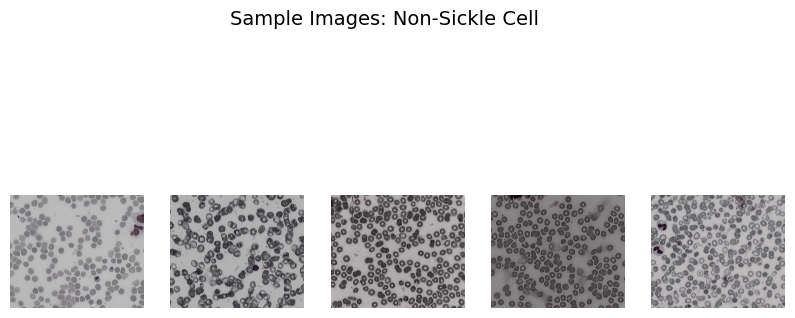

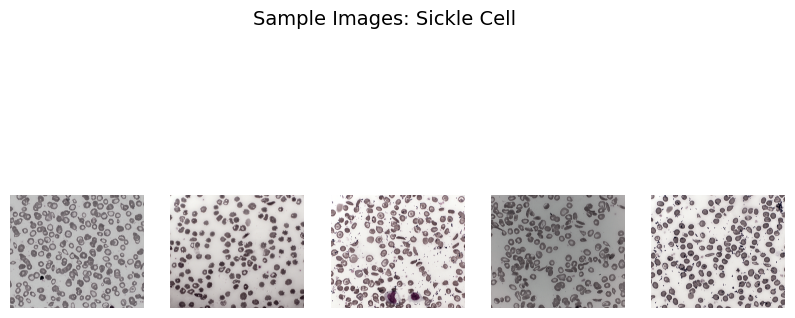

In [ ]:
## Display Sample Images

def display_samples(df, class_name, num_samples=5):
    sample_images = df.sample(n=num_samples, random_state=42)["image_path"].tolist()
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Sample Images: {class_name}", fontsize=14)
    plt.show()

# Display separate samples for each class
display_samples(df[df["class"] == 0], "Non-Sickle Cell")
display_samples(df[df["class"] == 1], "Sickle Cell")

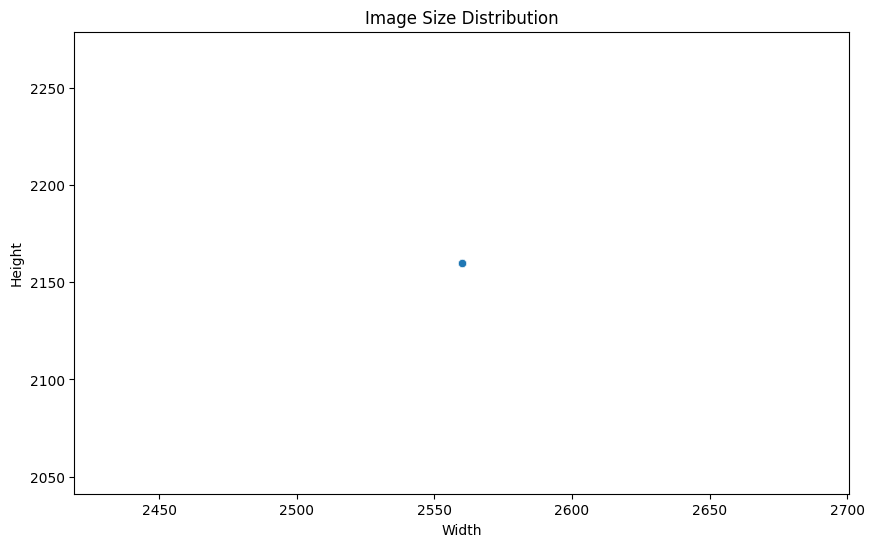

In [ ]:
## Image Size Distribution
image_sizes = []
for img_path in df["image_path"]:
    img = cv2.imread(img_path)
    if img is not None:
        image_sizes.append(img.shape[:2])

size_df = pd.DataFrame(image_sizes, columns=["Height", "Width"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=size_df, x="Width", y="Height")
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Size Distribution")
plt.show()

In [35]:
size_df.head()

,Height,Width,Aspect Ratio
0,2160,2560,1.185185
1,2160,2560,1.185185
2,2160,2560,1.185185
3,2160,2560,1.185185
4,2160,2560,1.185185


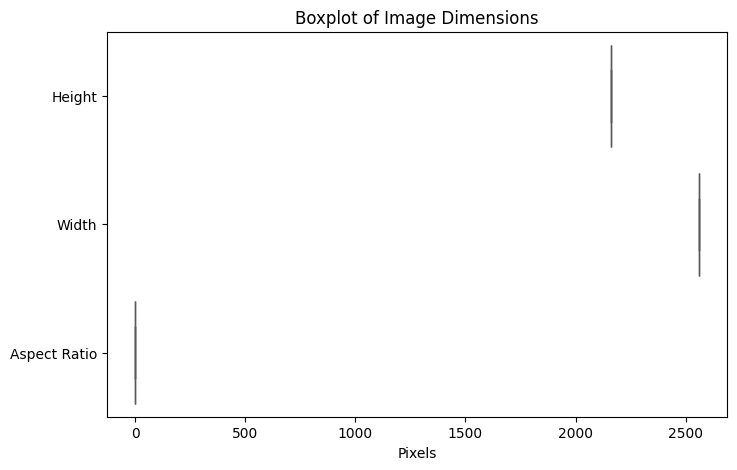

In [22]:
## Remove Correlation Matrix and Replace with Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=size_df, orient="h", palette="Set2")
plt.xlabel("Pixels")
plt.title("Boxplot of Image Dimensions")
plt.show()

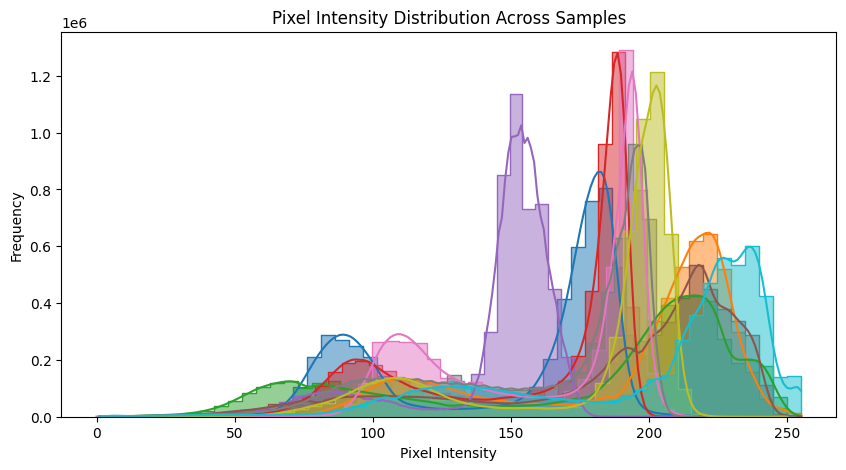

In [ ]:
## Pixel Intensity Distribution
plt.figure(figsize=(10, 5))
for img_path in df["image_path"].sample(10, random_state=42):  # 10 random images
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        sns.histplot(img.ravel(), kde=True, bins=50, element="step", alpha=0.5)
plt.title("Pixel Intensity Distribution Across Samples")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

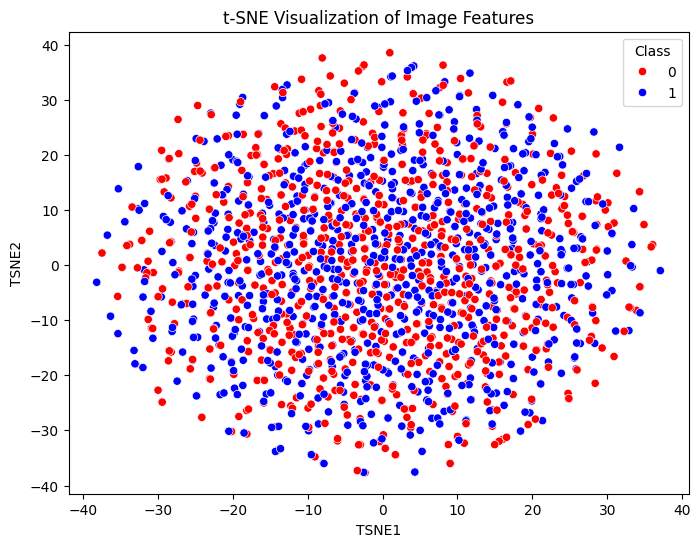

In [ ]:
## t-SNE Visualization (Feature Embedding)
tsne = TSNE(n_components=2, random_state=42)
image_vectors = np.random.rand(len(df), 128)  # Placeholder for feature extraction
tsne_results = tsne.fit_transform(image_vectors)
tsne_df = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
tsne_df["Class"] = df["class"].values
plt.figure(figsize=(8, 6))
sns.scatterplot(x="TSNE1", y="TSNE2", hue="Class", palette=["red", "blue"], data=tsne_df)
plt.title("t-SNE Visualization of Image Features")
plt.show()

In [34]:
# ============================
# 4. COMPARE SWIN TRANSFORMER MODELS
# ============================
model_variants = [
    "swin_tiny_patch4_window7_224",
    "swin_small_patch4_window7_224",
    "swin_base_patch4_window7_224",
    "swin_large_patch4_window7_224"
]

model_info = []
for model_name in model_variants:
    model = create_model(model_name, pretrained=True)
    num_params = sum(p.numel() for p in model.parameters())
    model_info.append([model_name, num_params])
    print(f"\nModel: {model_name}")
    print(model)
    print("\n-------------------------\n")


Model: swin_tiny_patch4_window7_224
SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(appr

<ipython-input-14-84a66a73c94a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_df, x="Model Name", y="Number of Parameters", palette="coolwarm")


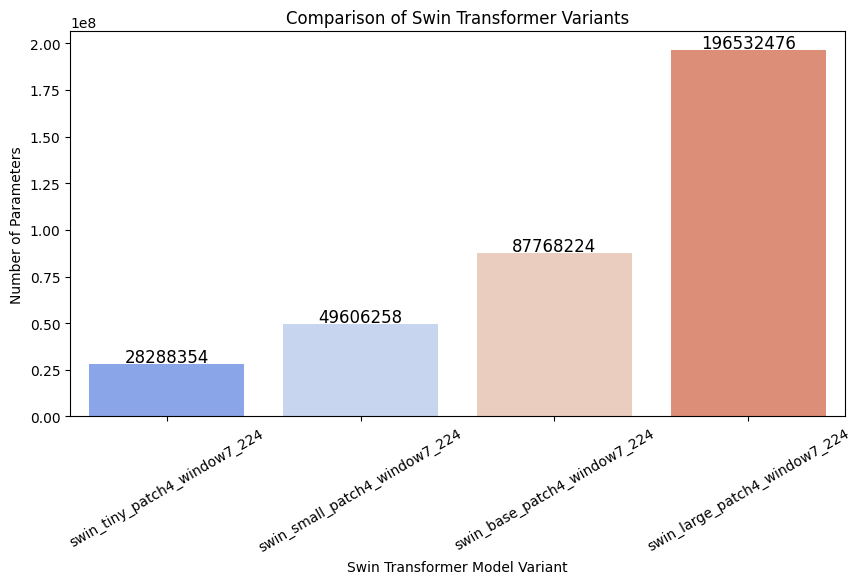

In [14]:
# Convert to DataFrame and visualize
model_df = pd.DataFrame(model_info, columns=["Model Name", "Number of Parameters"])
plt.figure(figsize=(10, 5))
sns.barplot(data=model_df, x="Model Name", y="Number of Parameters", palette="coolwarm")
plt.xlabel("Swin Transformer Model Variant")
plt.ylabel("Number of Parameters")
plt.title("Comparison of Swin Transformer Variants")
for i, v in enumerate(model_df["Number of Parameters"]):
    plt.text(i, v + 1e6, str(v), ha='center', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [15]:
# ============================
# 5. LOAD SWIN TRANSFORMER MODEL
# ============================
selected_model = "swin_tiny_patch4_window7_224"
model = create_model(selected_model, pretrained=True)

# Display model summary
print("\nSelected Swin Transformer Model Summary:")
model


Selected Swin Transformer Model Summary:


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [23]:
from torchsummary import summary

# Ensure model is on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Display model summary
print("\nSelected Swin Transformer Model Summary:")
summary(model, (3, 224, 224))  # Assuming input image size is 224x224



Selected Swin Transformer Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
         LayerNorm-2           [-1, 56, 56, 96]             192
        PatchEmbed-3           [-1, 56, 56, 96]               0
          Identity-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6              [-1, 49, 288]          27,936
           Softmax-7            [-1, 3, 49, 49]               0
           Dropout-8            [-1, 3, 49, 49]               0
            Linear-9               [-1, 49, 96]           9,312
          Dropout-10               [-1, 49, 96]               0
  WindowAttention-11               [-1, 49, 96]               0
         Identity-12           [-1, 56, 56, 96]               0
        LayerNorm-13             [-1, 3136, 96]             1

<ipython-input-30-24904520d995>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_layer_df, x="Layer Type", y="Parameters", palette="coolwarm")


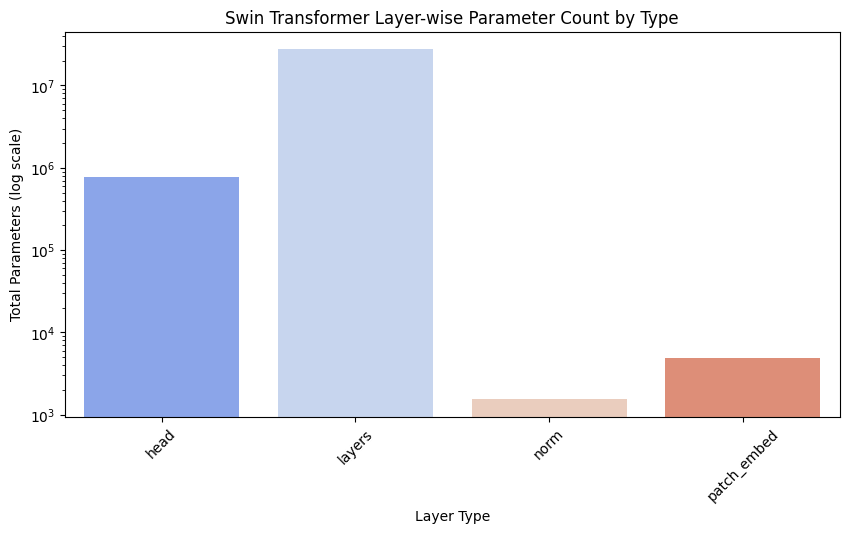

In [30]:
layer_types = [name.split('.')[0] for name in layer_df["Layer"]]
layer_df["Layer Type"] = layer_types
grouped_layer_df = layer_df.groupby("Layer Type")["Parameters"].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=grouped_layer_df, x="Layer Type", y="Parameters", palette="coolwarm")
plt.xticks(rotation=45)
plt.yscale("log")
plt.xlabel("Layer Type")
plt.ylabel("Total Parameters (log scale)")
plt.title("Swin Transformer Layer-wise Parameter Count by Type")
plt.show()
